# Calorimeter regression task

In this project you will be looking at image like data from particle hits in a calorimeter. The goal of the project is to predict the location of the particle in the sky, using the data recorded by the calorimeter. Look in the `README.md` for more information.

First download the data, and then un-zip the data with `tar -zxvf data.tar.gz` into a data folder.
1. You can then use the functions within `utils.py` to load the data
2. We run `get_input_data` below to load in the images 

You may need to edit the `get_input_data` function in `utils.py` to have the right path.

## The training data
Here you get calorimeter images, as well as some additional information about the calorimeter.
The calorimeter data has the total energy of the corresponding image in the first column, and the calorimeter energy of the maximum bar.

## The target data
The target here is a vector of length four, where the first two columns are the x coordinates at the bottom and top, and then the y positions at the top and the bottom. To simplify the task, you can try predicting each layer individually, before attempting both layers together.
Top and bottom is relative to the tracker in the detector at -40mm and -200mm in z.


In [1]:
import os 
from utils import get_input_data
import numpy as np 
import helpers
import plotter 
from helpers import split_xy_intercept, order_xy_intercept, get_data_dict, sort_data_by_energy, split_dico, save_model, save_model_history, load_model_history
from plotter import plot_image, plot_model_history, plot_split_distribution, plot_energy
import matplotlib.pyplot as plt

# ML tools 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Input, losses, saving

from dampe_ai import split_train_val_test, calorimeter_model, std_compile, std_fit, std_compile_fit

import pdb

2024-06-15 21:07:22.023818: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 21:07:22.062882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 21:07:22.843909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Usefull flags and hyperparameters
load_models = False
save_models = True
epochs      = 80

val_size  = 0.2
test_size = 0.5

Load all the data

In [3]:
calorimeter_images, calorimeter_data, data_target, benchmark_data = get_input_data()

In [4]:
# Normalize the data 
calorimeter_images = calorimeter_images / 255.0
# calorimeter_images = calorimeter_images.reshape(calorimeter_images.shape[:3])/ 255.0

#### Data structure:

`calorimeter_images`: Calorimeter images

`calorimeter_data`: Calorimeter 2 variables  - bgoene (CALO total energy), maxbar (CALO energy of maximum bar)

`data_target`: Truth/target 4 variables - normally variables that are targeted at the regression optimisation,
say x_bot, x_top, y_bot, y_top

`benchmark_data`: Benchmark predictions 4 variables - Obtained from the standard BGO rec direction, x_bot, x_top, y_bot, y_top 

In [5]:
print(f"Input images of shape: {calorimeter_images.shape}255. and type {type(calorimeter_images)}")
print(f"Input data of shape: {calorimeter_data.shape} and type {type(calorimeter_data)}")
print(f"Target data of shape: {data_target.shape} and type {type(data_target)}")
print(f"Benchmark data of shape: {benchmark_data.shape} and type {type(benchmark_data)}")

Input images of shape: (141946, 14, 22, 1)255. and type <class 'numpy.ndarray'>
Input data of shape: (141946, 2) and type <class 'numpy.ndarray'>
Target data of shape: (141946, 4) and type <class 'numpy.ndarray'>
Benchmark data of shape: (141946, 4) and type <class 'numpy.ndarray'>


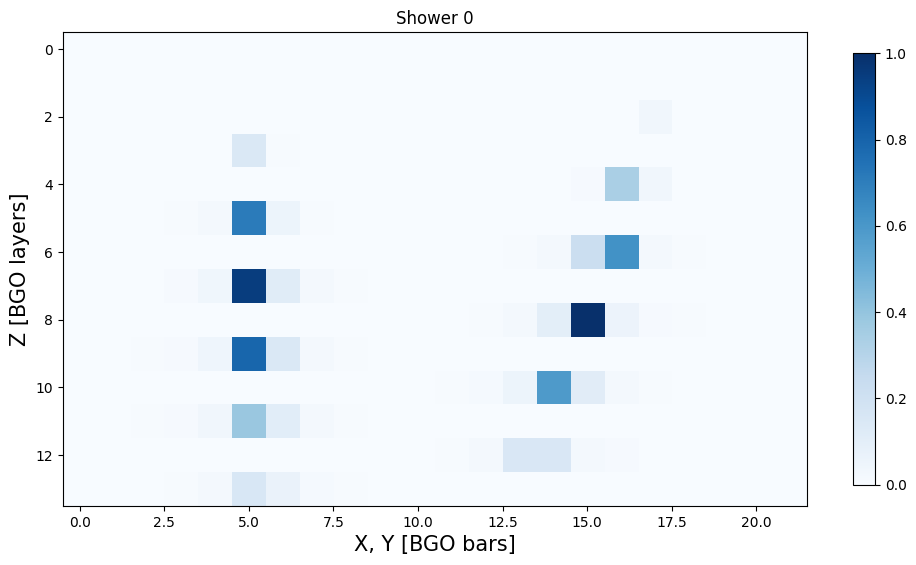

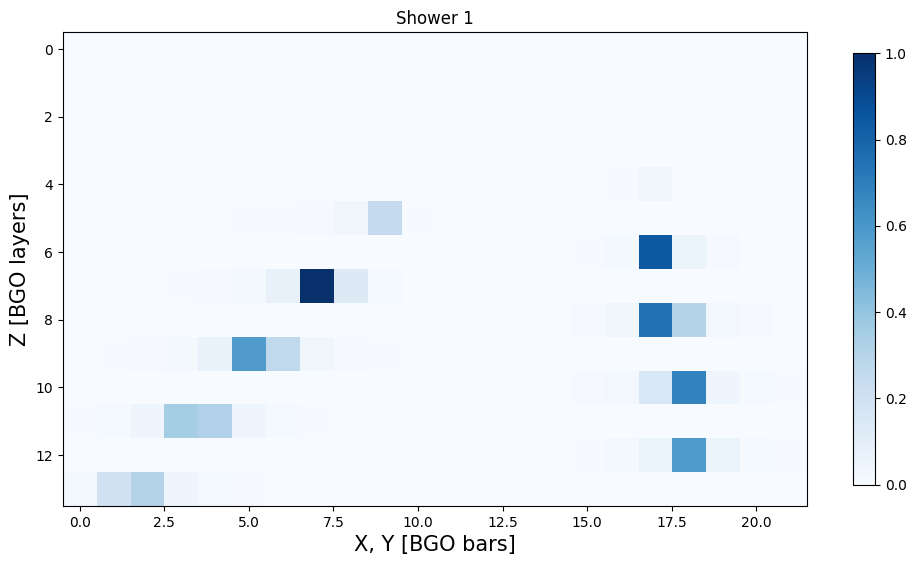

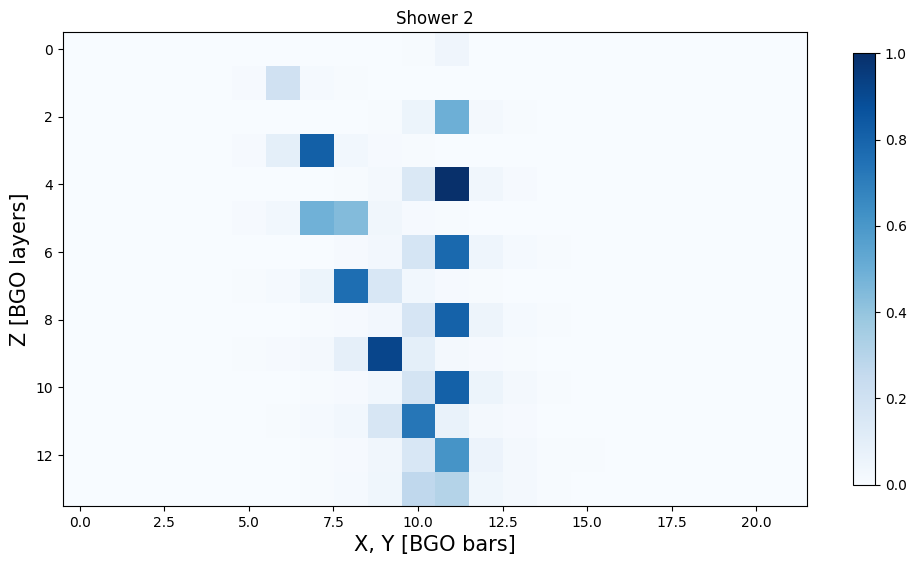

In [6]:
%matplotlib inline
#fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(21,6))
for i in range(3):
    plot_image(calorimeter_images[i], image_name = 'Shower {}'.format(i))

Here we can see the structure of the data in image format for the first three showers.

The total energy of the shower and the max energy of a bar are also shown.

Note that there seem to be two lines alternating every row - this is the x-z and y-z split of the calormiter alternating each layer!

**The exercises can be found in the `README.md`**


Question : Is it starting with the x intercept or with the y intercept? Is the first row the x intercept and the second the y intercept or is it reversed?

(141946, 14, 22, 1)


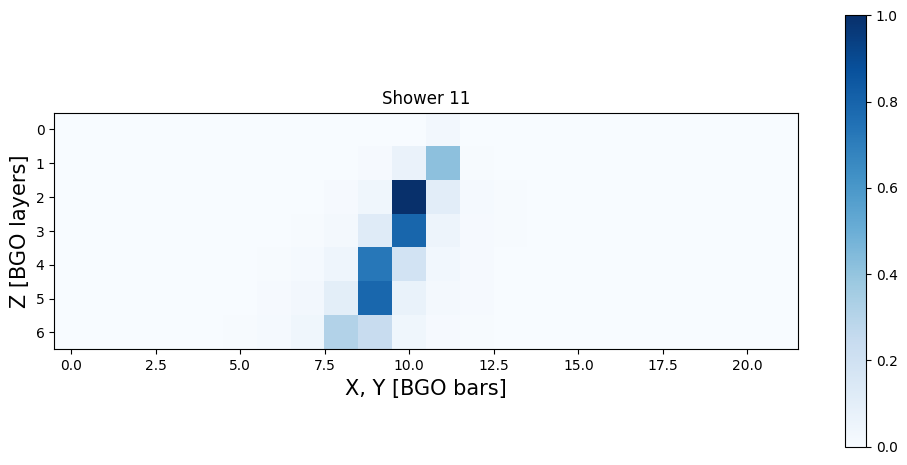

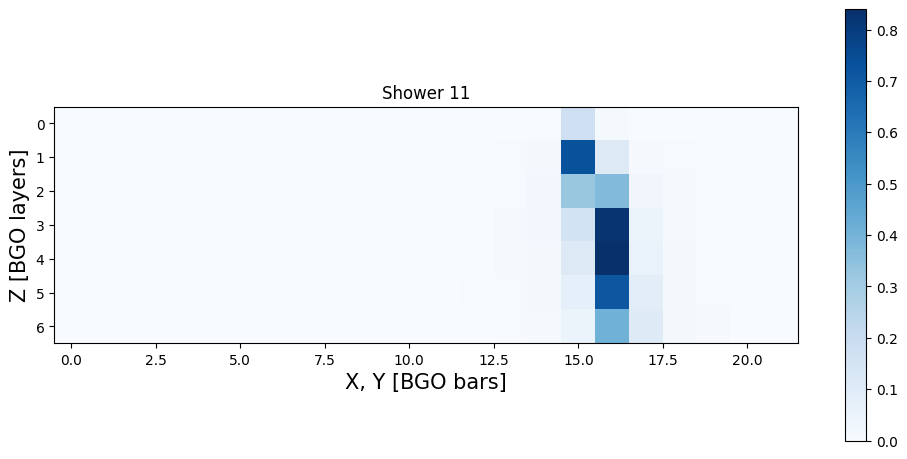

(<Figure size 1200x700 with 2 Axes>,
 <Axes: title={'center': 'Shower 11'}, xlabel='X, Y [BGO bars]', ylabel='Z [BGO layers]'>)

In [7]:
print(calorimeter_images.shape)
X, Y = split_xy_intercept(calorimeter_images)
plot_image(X[11], loglevel = True, image_name = 'Shower {}'.format(11))
plot_image(Y[11], image_name = 'Shower {}'.format(11))

Plot the image

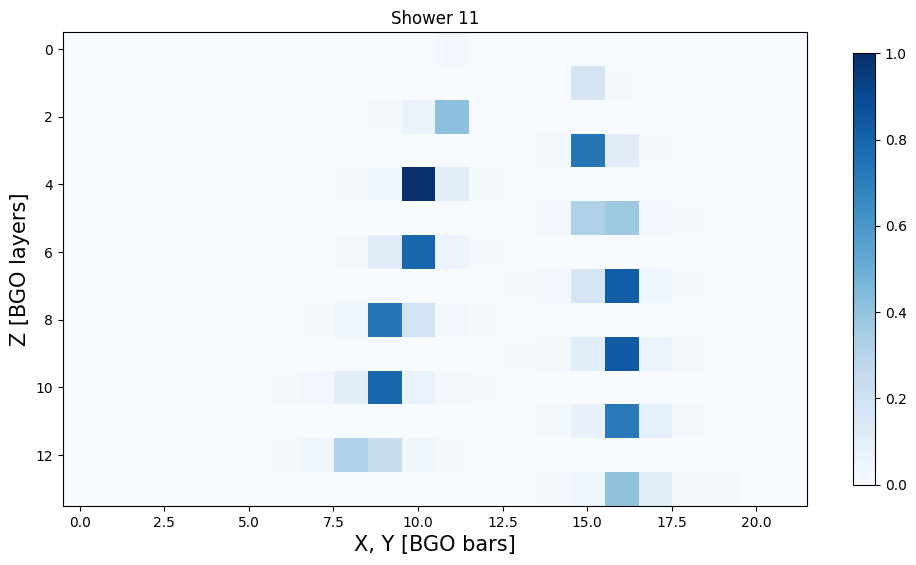

[11605430.    1045136.56]
[101.87327 116.62327  72.93379  37.35789]
[ 98.75 114.56  75.56  38.75]


In [8]:
shower_n = 11
plot_image(calorimeter_images[shower_n], image_name = 'Shower {}'.format(shower_n))

# Show the data first 
print(calorimeter_data[shower_n])
print(data_target[shower_n])
print(benchmark_data[shower_n])

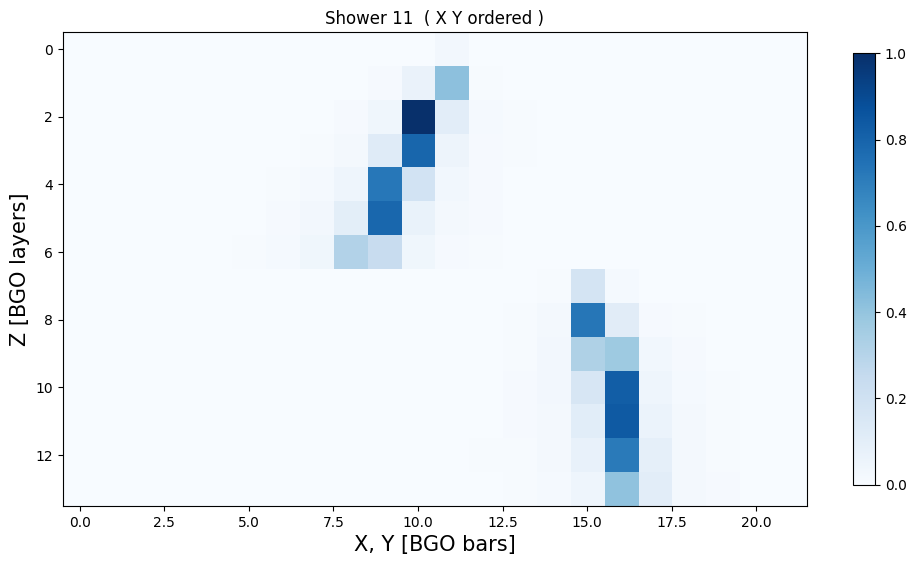

(<Figure size 1200x700 with 2 Axes>,
 <Axes: title={'center': 'Shower 11  ( X Y ordered )'}, xlabel='X, Y [BGO bars]', ylabel='Z [BGO layers]'>)

In [9]:
# Data process
XY = order_xy_intercept(calorimeter_images)
plot_image(XY[shower_n], loglevel = True, image_name = 'Shower {}  ( X Y ordered )'.format(11))

Without further processing we directly apply a convolutional neural network for the regression task.

We start by spliting in 3 sets : \
Test  \
Train \
Validation

In [10]:
# Normalize the data
# Split parameters
dampe_dic  = get_data_dict()
dampe_data = dampe_dic

Im_train, Im_val, Im_test, xy_train, xy_val, xy_test, energy_train, energy_val, energy_test = split_train_val_test(dampe_data = dampe_dic, val_size=val_size, test_size=test_size)

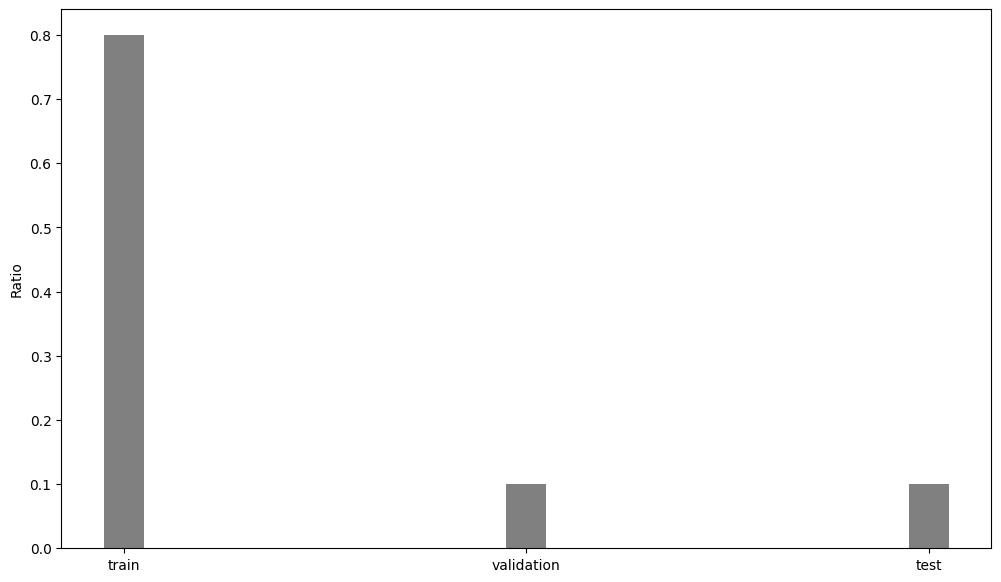

In [11]:
plot_split_distribution(dampe_dic, xy_train, xy_val, xy_test, figname='split_distribution.png');

In [ ]:
if load_models:
    model_mix   = saving.load_model('./models/model_mix.keras')
    history_mix = helpers.load_model_history('./models/model_mix.json')
else:
    model_mix = calorimeter_model(dampe_dic, model_type = 4)
    # Compile and fit
    model_mix, history_mix = std_compile_fit(model_mix, [Im_train, energy_train], [Im_val, energy_val], [xy_train], [xy_val], epochs = epochs)
model_mix.summary()

2024-06-15 21:07:30.762811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 21:07:30.763159: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/80
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 16879.6484 - mean_absolute_error: 97.6144 - mean_squared_error: 16879.6484 - val_loss: 1662.7659 - val_mean_absolute_error: 28.7217 - val_mean_squared_error: 1661.4967
Epoch 2/80
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1254.3193 - mean_absolute_error: 24.8751 - mean_squared_error: 1254.3193 - val_loss: 621.2555 - val_mean_absolute_error: 17.6385 - val_mean_squared_error: 620.1061
Epoch 3/80
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 506.1955 - mean_absolute_error: 16.0350 - mean_squared_error: 506.1955 - val_loss: 428.7981 - val_mean_absolute_error: 14.9727 - val_mean_squared_error: 427.9879
Epoch 4/80
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 340.1894 - mean_absolute_error: 13.1189 - mean_squared_error: 340.1894 - val_loss: 370.8410 - val_mean_absolute_error: 14.5052 - val_mean_squared_error: 370.0040
Epoch 5/80
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 248.5396 - mean_absolute_erro

In [ ]:
if save_models: 
    save_model(model_mix, 'model_mix')
    save_model_history(history_mix, 'model_mix')   

In [14]:
if load_models:
    model1   = saving.load_model('./models/model1.keras')
    history1 = helpers.load_model_history('./models/model1.json')
else:
    model1 = calorimeter_model(dampe_dic, model_type = 1)
    # Compile and fit
    model1, history1 = std_compile_fit(model1, Im_train, Im_val, xy_train, xy_val, epochs = epochs)
model1.summary()

TypeError: <class 'keras.src.losses.losses.MeanSquaredError'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'reduction': 'auto', 'name': 'mean_squared_error', 'fn': 'mean_squared_error'}, 'registered_name': None}.

Exception encountered: MeanSquaredError.__init__() got an unexpected keyword argument 'fn'

In [ ]:
if save_models: 
    save_model(model1, 'model1')
    save_model_history(history1, 'model1')    

In [ ]:
if load_models:
    model2   = keras.saving.load_model('./models/model2.keras')
    history2 = helpers.load_model_history('./models/model2.json')
else:
    model2 = calorimeter_model(dampe_dic, model_type = 2)
    # Compile and fit
    model2, history2 = std_compile_fit(model2, Im_train, Im_val, xy_train, xy_val, epochs = epochs)
model2.summary()

In [ ]:
if save_models: 
    save_model(model2, 'model2')
    save_model_history(history2, 'model2')    

In [ ]:
plot_model_history([history1,history2],loglevel=True,savefig=True, figname='history12', label_str = ['_model1', '_model2']);

In [ ]:
# Predict from the validation 
xy_prediction = model1.predict(Im_val)

Separate the energy levels

In [ ]:
sorted_dic, sorted_idx = sort_data_by_energy('total')

In [12]:
split_dampe = split_dico(sorted_dic, frac=[0.5, 0.5])

NameError: name 'sorted_dic' is not defined

In [13]:
# Split the data in train, validation and test
Im_train_low , Im_val_low , Im_test_low , xy_train_low , xy_val_low , xy_test_low  = split_train_val_test(split_dampe[0], val_size = 0.2, test_size = 0.4)
Im_train_high, Im_val_high, Im_test_high, xy_train_high, xy_val_high, xy_test_high = split_train_val_test(split_dampe[1], val_size = 0.2, test_size = 0.4)

NameError: name 'split_dampe' is not defined

Build the splited model 

In [ ]:
if load_models:
    model_low   = keras.saving.load_model('./models/model_low.keras')
    history_low = helpers.load_model_history('./models/model_low.json')
else:
    model_low = calorimeter_model(split_dampe[0], model_type = 3)
    # Compile and fit
    model_low, history_low = std_compile_fit(model_low, Im_train_low, Im_val_low, xy_train_low, xy_val_low, epochs = epochs)
model_low.summary()

In [ ]:
if save_models: 
    save_model(model_low, 'model_low')
    save_model_history(history_low, 'model_low')    

In [ ]:
if load_models:
    model_high   = keras.saving.load_model('./models/model_high.keras')
    history_high = helpers.load_model_history('./models/model_high.json')
else:
    model_high = calorimeter_model(split_dampe[1], model_type = 3)
    model_high.summary()
    # Compile and fit
    model_high, history_high = std_compile_fit(model_high, Im_train_high, Im_val_high, xy_train_high, xy_val_high, epochs = epochs)

In [ ]:
if save_models: 
    save_model(model_high, 'model_high')
    save_model_history(history_high, 'model_high')   

In [ ]:
plot_model_history([history_low,history_high],loglevel=True, savefig=True, figname='history_split', label_str=['_low_energy', '_high_energy']);

In [ ]:
plot_energy(sorted_dic, loglevel=False, figname='energy.png');
plot_energy(sorted_dic, loglevel=True, figname ='energy_log.png');